In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

In [2]:
device = torch.device("cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def PoissonGen(inp, rescale_fac=2.0):
    rand_inp = torch.rand_like(inp)
    return torch.mul(torch.le(rand_inp * rescale_fac, torch.abs(inp)).float(), torch.sign(inp))

def spike_function(x, k):
    x[x>0] = 1
    x[x<=0] = 0
    return x

def de_func(U,th):
    alpha = 0.3
    U = alpha*(1.0 - abs((U-th)/th))
    U[U<0]=0
    return U

def test():
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = toy(data)
        test_loss +=F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        
        self.fc_1 = nn.Linear(28*28,6,bias=False)
        self.fc_2 = nn.Linear(6,4,bias=False)
        self.fc_out = nn.Linear(4,10,bias=False)
        self.lif1 = LIF()
        self.lif2 = LIF()
        self.time_step = 10
        self.s_regs_inp = None
        
    def forward(self, inp):
        inp = inp.view(inp.shape[0],-1)
        size = inp.shape
        self.s_regs_inp = torch.zeros(self.time_step,*size)
        u_out = 0
        
        for t in range(self.time_step):
            
            spike_inp = PoissonGen(inp)
            self.s_regs_inp[t] += spike_inp 
            
            x = self.fc_1(spike_inp)
            x = self.lif1(x, t)
            x = self.fc_2(x)
            x = self.lif2(x, t)
            x = self.fc_out(x)
            u_out = u_out + x
        return u_out

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.fc_1 = nn.Linear(28*28,512,bias=False)
        self.fc_out = nn.Linear(512,10,bias=False)
        self.lif1 = LIF()
        self.time_step = 7
        self.s_regs_inp = None
        
    def forward(self, inp):
        
        inp = inp.view(inp.shape[0],-1)
        size = inp.shape
        self.s_regs_inp = torch.zeros(self.time_step,*size)
        u_out = 0
        
        for t in range(self.time_step):
            spike_inp = PoissonGen(inp)
            self.s_regs_inp[t] += spike_inp 

            x = self.fc_1(spike_inp)
            x = self.lif1(x, t)
            x = self.fc_out(x)
            u_out = u_out + x
        return u_out
        

In [6]:
class LIF(nn.Module):
    def __init__(self):
        super(LIF, self).__init__()
        
        self.u_regs = None
        self.du_regs = None
        self.s_regs = None
        self.leak = 0.99
        self.time_step = 7
        self.thresh = 0.5
        
    def forward(self,inp,t):
        if t == 0:
            size = inp.shape
            self.u_regs = torch.zeros(self.time_step,*size)
            self.du_regs = torch.zeros(self.time_step,*size)
            self.u_regs[0] = inp
            self.s_regs = torch.zeros(self.time_step,*size)

            vol = inp - self.thresh

            spike = spike_function(vol, k=1)

            self.s_regs[0] = spike
        else:
            self.u_regs[t] = self.leak * self.u_regs[t-1] * (1 - self.s_regs[t-1]) + inp

            vol = self.u_regs[t] - self.thresh

            spike = spike_function(vol, k=1)

            self.s_regs[t] = spike
        return spike


In [7]:
### Back propagation for MLP
def bp_MLP(toy,leak,time_step,du_out,s_regs_inp,l_r,th):
    
    ## First fc
    du_fc1 = torch.matmul(du_out,toy.fc_out.weight)*de_func(toy.lif1.u_regs[-1],th)
    toy.lif1.du_regs[-1] += du_fc1

    ## Update weight
    w_inp_1 = torch.matmul(torch.transpose(du_fc1,0,1),s_regs_inp[-1])
    toy.fc_1.weight.data -= l_r*w_inp_1

    w_1_out = torch.matmul(torch.transpose(du_out,0,1),toy.lif1.s_regs[-1])
    toy.fc_out.weight.data -= l_r*w_1_out

    for t in range(time_step-2,-1,-1):
        
        ## First fc
        ds_fc1 = torch.matmul(du_out,toy.fc_out.weight)+toy.lif1.du_regs[t+1]*(-leak*toy.lif1.u_regs[t])
        du_fc1 = (ds_fc1)*de_func(toy.lif1.u_regs[t],th) + toy.lif1.du_regs[t+1]*leak*(1-toy.lif1.s_regs[t])
        toy.lif1.du_regs[t] += du_fc1

        ## Update weight
        w_inp_1 = torch.matmul(torch.transpose(du_fc1,0,1),s_regs_inp[t])
        toy.fc_1.weight.data -= l_r*w_inp_1

        w_1_out = torch.matmul(torch.transpose(du_out,0,1),toy.lif1.s_regs[t])
        toy.fc_out.weight.data -= l_r*w_1_out


In [8]:
### Back propagation
def bp(toy,leak,time_step,du_out,s_regs_inp,l_r,th):
    
    ## Second fc    
    du_fc2 = torch.matmul(du_out,toy.fc_out.weight)*de_func(toy.lif2.u_regs[-1],th)    
    toy.lif2.du_regs[-1] = toy.lif2.du_regs[-1] + du_fc2
    
    ## First fc
    du_fc1 = torch.matmul(du_fc2,toy.fc_2.weight)*de_func(toy.lif1.u_regs[-1],th)
    toy.lif1.du_regs[-1] += du_fc1

    
    ## Update weight
    w_inp_1 = torch.matmul(torch.transpose(du_fc1,0,1),s_regs_inp[-1])
    toy.fc_1.weight.data += w_inp_1

    w_1_2 = torch.matmul(torch.transpose(du_fc2,0,1),toy.lif1.s_regs[-1])
    toy.fc_2.weight.data += w_1_2

    w_2_out = torch.matmul(torch.transpose(du_out,0,1),toy.lif2.s_regs[-1])
    toy.fc_out.weight.data += w_2_out

    for t in range(time_step-2,-1,-1):

        ds_fc2 = torch.matmul(du_out,toy.fc_out.weight)+toy.lif2.du_regs[t+1]*(-leak*toy.lif2.u_regs[t])
        du_fc2 = (ds_fc2)*de_func(toy.lif2.u_regs[t],th) + toy.lif2.du_regs[t+1]*leak*(1-toy.lif2.s_regs[t])
        toy.lif2.du_regs[t] += du_fc2
        
        ## First fc
        ds_fc1 = torch.matmul(du_fc2,toy.fc_2.weight)+toy.lif1.du_regs[t+1]*(-leak*toy.lif1.u_regs[t])
        du_fc1 = (ds_fc1)*de_func(toy.lif1.u_regs[t],th) + toy.lif1.du_regs[t+1]*leak*(1-toy.lif1.s_regs[t])
        toy.lif1.du_regs[t] += du_fc1

        ## Update weight
        w_inp_1 = torch.matmul(torch.transpose(du_fc1,0,1),s_regs_inp[t])
        toy.fc_1.weight.data -= l_r*w_inp_1

        w_1_2 = torch.matmul(torch.transpose(du_fc2,0,1),toy.lif1.s_regs[t])
        toy.fc_2.weight.data -= l_r*w_1_2

        w_2_out = torch.matmul(torch.transpose(du_out,0,1),toy.lif2.s_regs[t])
        toy.fc_out.weight.data -= l_r*w_2_out


In [9]:
import torch
import torchvision

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [10]:
test_losses = []
train_losses = []
train_counter = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]
log_interval = 10

In [11]:
toy = MLP()
leak = 0.99
time_step = 7
lr = 0.001
loss = nn.CrossEntropyLoss()

test()
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        out = toy(data)
            
        err = loss(out,target)
        exp = torch.exp(out)
        exp_sum = torch.sum(torch.exp(out),1, keepdim=True)
        target = F.one_hot(target, num_classes=10)
        L = -1*torch.sum((target*torch.log((exp/exp_sum))),1, keepdim=True)
        
        
        du_out = exp/exp_sum

        du_out = du_out - target
        
        bp_MLP(toy,leak,time_step,du_out,toy.s_regs_inp,lr,toy.lif1.thresh)
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), err.item()))
            train_losses.append(err.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    test()


C:\Users\Ruokai\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.9761, Accuracy: 804/10000 (8%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.781648
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.486200
Train Epoch: 0 [1280/60000 (2%)]	Loss: 1.063899
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.946516
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.475169
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.845716
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.596982
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.444111
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.170122
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.466288
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.457892
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.385550
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.531666
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.353850
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.241993
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.578200
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.406024
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.491234
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.437475
Train Epoch: 0 [12160/6

Train Epoch: 1 [44160/60000 (74%)]	Loss: 0.128370
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.090279
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.148628
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.043487
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.084799
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.043776
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.053157
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.128357
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.067644
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.074848
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.308066
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.051546
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.086995
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.079986
Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.240099
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.122918
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.030615
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.073550
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.025258
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.158965


Train Epoch: 3 [28160/60000 (47%)]	Loss: 0.069337
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.152139
Train Epoch: 3 [29440/60000 (49%)]	Loss: 0.089940
Train Epoch: 3 [30080/60000 (50%)]	Loss: 0.101312
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.210995
Train Epoch: 3 [31360/60000 (52%)]	Loss: 0.159481
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.036070
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.063915
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.126666
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.138443
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.058893
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.095009
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.057666
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.081935
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.052513
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.140301
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.037486
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.064817
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.041535
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.050200


Train Epoch: 5 [12160/60000 (20%)]	Loss: 0.023062
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.002852
Train Epoch: 5 [13440/60000 (22%)]	Loss: 0.012741
Train Epoch: 5 [14080/60000 (23%)]	Loss: 0.093364
Train Epoch: 5 [14720/60000 (25%)]	Loss: 0.005313
Train Epoch: 5 [15360/60000 (26%)]	Loss: 0.014267
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.011626
Train Epoch: 5 [16640/60000 (28%)]	Loss: 0.016942
Train Epoch: 5 [17280/60000 (29%)]	Loss: 0.015498
Train Epoch: 5 [17920/60000 (30%)]	Loss: 0.041558
Train Epoch: 5 [18560/60000 (31%)]	Loss: 0.020850
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.045164
Train Epoch: 5 [19840/60000 (33%)]	Loss: 0.036429
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.024036
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.121536
Train Epoch: 5 [21760/60000 (36%)]	Loss: 0.060491
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.019593
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.042625
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.031935
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.021458


Train Epoch: 6 [56960/60000 (95%)]	Loss: 0.092953
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.045912
Train Epoch: 6 [58240/60000 (97%)]	Loss: 0.010109
Train Epoch: 6 [58880/60000 (98%)]	Loss: 0.059042
Train Epoch: 6 [59520/60000 (99%)]	Loss: 0.092663

Test set: Avg. loss: 0.0869, Accuracy: 9743/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.014286
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.031361
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.008034
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.027296
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.017435
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.028340
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.050966
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.008290
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.015677
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.012911
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.013165
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.018119
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.023952
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.017217
Train Epoch: 7 [896

Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.003027
Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.112878
Train Epoch: 8 [42240/60000 (70%)]	Loss: 0.014926
Train Epoch: 8 [42880/60000 (71%)]	Loss: 0.005764
Train Epoch: 8 [43520/60000 (72%)]	Loss: 0.006236
Train Epoch: 8 [44160/60000 (74%)]	Loss: 0.032870
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.006726
Train Epoch: 8 [45440/60000 (76%)]	Loss: 0.245355
Train Epoch: 8 [46080/60000 (77%)]	Loss: 0.003886
Train Epoch: 8 [46720/60000 (78%)]	Loss: 0.022307
Train Epoch: 8 [47360/60000 (79%)]	Loss: 0.005576
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.014088
Train Epoch: 8 [48640/60000 (81%)]	Loss: 0.038464
Train Epoch: 8 [49280/60000 (82%)]	Loss: 0.061883
Train Epoch: 8 [49920/60000 (83%)]	Loss: 0.116366
Train Epoch: 8 [50560/60000 (84%)]	Loss: 0.049728
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.018903
Train Epoch: 8 [51840/60000 (86%)]	Loss: 0.058023
Train Epoch: 8 [52480/60000 (87%)]	Loss: 0.012012
Train Epoch: 8 [53120/60000 (88%)]	Loss: 0.043666


Text(0, 0.5, 'negative log likelihood loss')

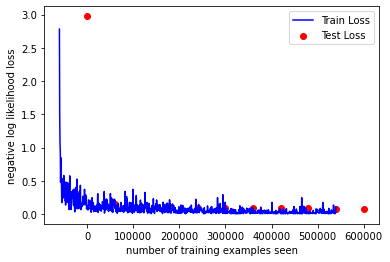

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')